In [1]:
import sys
sys.path.append("../unet/")

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
% matplotlib inline

from keras_unet import build_unet, mean_iou, my_sigmoid_cross_entropy, pixelwise_weighted_cross_entropy_loss
from keras.models import Model, load_model
from my_utils import load_saved_data, plots
from SegDataGenerator import rgb2gray
from skimage.transform import resize
import os
from skimage.io import imread
from skimage.morphology import label

from SegDataGenerator import SegDataGenerator

/Users/Kazu/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [30]:
USE_WEIGHTS = True
RGB = False
IMG_HEIGHT = IMG_WIDTH= 256
IMG_CHANNELS = 3 if RGB else 1

In [35]:
models_path = '../unet/models/'
model_name = 'gray_256_testmylossoneweights_28'
model_path = models_path + model_name + '.hdf5'

# unet_rgb_batchnorm_24
# unet_rgb_weights_08.hdf5
# unet_grayscale_weights.hdf5
custom_objects = {'mean_iou': mean_iou, 
                                   'my_sigmoid_cross_entropy': my_sigmoid_cross_entropy, 
                                   'pixelwise_weighted_cross_entropy_loss': pixelwise_weighted_cross_entropy_loss}
model = load_model(model_path, custom_objects=custom_objects)

# OLD - load from weights. Note that we need to turn off batchnorm for models that are saved like this
# model = build_unet(0.0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, USE_WEIGHTS)
# model.load_weights(weights_path)

In [21]:
data_path = '../data/dataset_fixed_256x256.npz'
X_train, Y_train, C_train, W_train, X_test = load_saved_data(data_path, image_size=(IMG_HEIGHT, IMG_WIDTH))

# TODO convert to grayscale
if not RGB:
    X_train_gray = np.zeros((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_test_gray = np.zeros((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
    for i in range(X_train.shape[0]):
        X_train_gray[i,:,:,:] = rgb2gray(X_train[i,:,:,:])
    for i in range(X_test.shape[0]):
        X_test_gray[i,:,:,:] = rgb2gray(X_test[i,:,:,:])    
    X_train = X_train_gray
    X_test = X_test_gray
    
split = 0.8
X_train, Y_train = X_train[:int(X_train.shape[0]*split)], Y_train[:int(X_train.shape[0]*split)]
X_val, Y_val = X_train[int(X_train.shape[0]*split):], Y_train[int(X_train.shape[0]*split):]

Reading from previously loaded data.


In [36]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# preds_train = model.predict_generator(train_data, verbose=1)
# preds_val = model.predict_generator(val_data, verbose=1)
# preds_test = model.predict_generator(test_data, verbose=1)

# Threshold predictions - TODO figure out what happens without this
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

TEST_PATH = '../data/stage1_test/'
test_ids = next(os.walk(TEST_PATH))[1]

# Drop garbage layer if using weights
if USE_WEIGHTS:
    preds_train = preds_train[:,:,:,0]
    preds_val = preds_val[:,:,:,0]
    preds_test = preds_test[:,:,:,0]
    preds_train_t = preds_train_t[:,:,:,0]
    preds_val_t = preds_val_t[:,:,:,0]
    preds_test_t = preds_test_t[:,:,:,0]

# Create list of upsampled test masks
sizes_test = []
print('Getting test image sizes ...')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])

preds_test_upsampled = []
for i in range(len(preds_test)):
    pred = preds_test[i] 
    preds_test_upsampled.append(resize(np.squeeze(pred), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 22s 339ms/step


  6%|▌         | 4/65 [00:00<00:01, 35.73it/s]

Getting test image sizes ...


100%|██████████| 65/65 [00:01<00:00, 63.59it/s]


IndexError: too many indices for array

317
40 571
81 612
84 615
52 583
44 575


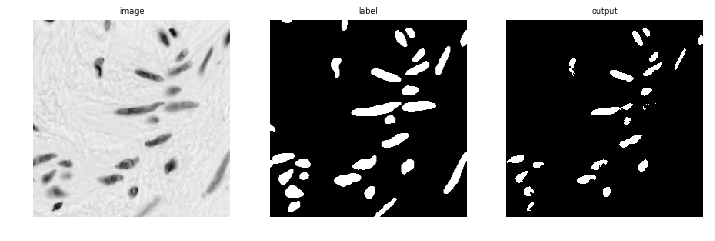

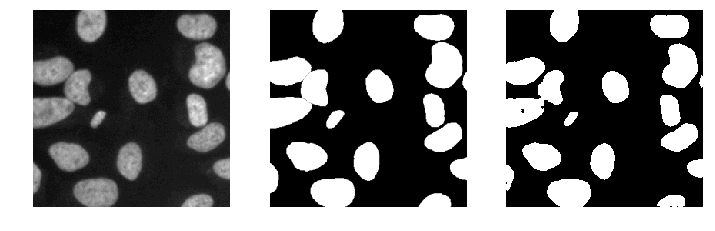

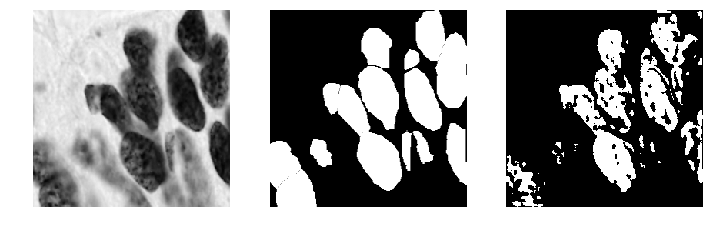

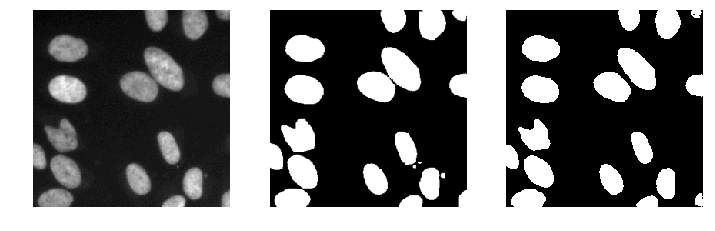

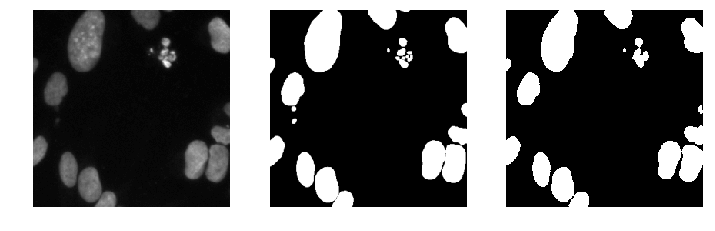

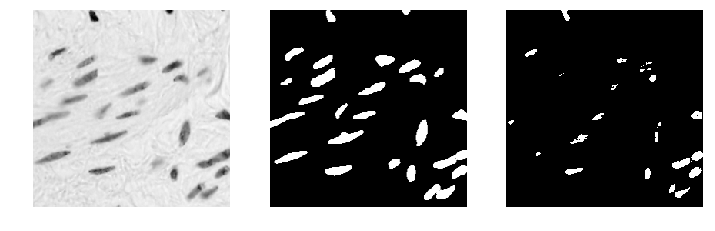

In [39]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t)); print(ix)
plots([X_train[ix], 
       Y_train[ix], 
       preds_train_t[ix]], 
       titles=['image', 'label', 'output'])

# Perform a sanity check on some random validation samples
for _ in range(5):
    ix = random.randint(0, len(preds_val_t)-1); print(ix, ix+X_train.shape[0])
    plots([X_val[ix], 
          Y_val[ix], 
          preds_val_t[ix]])

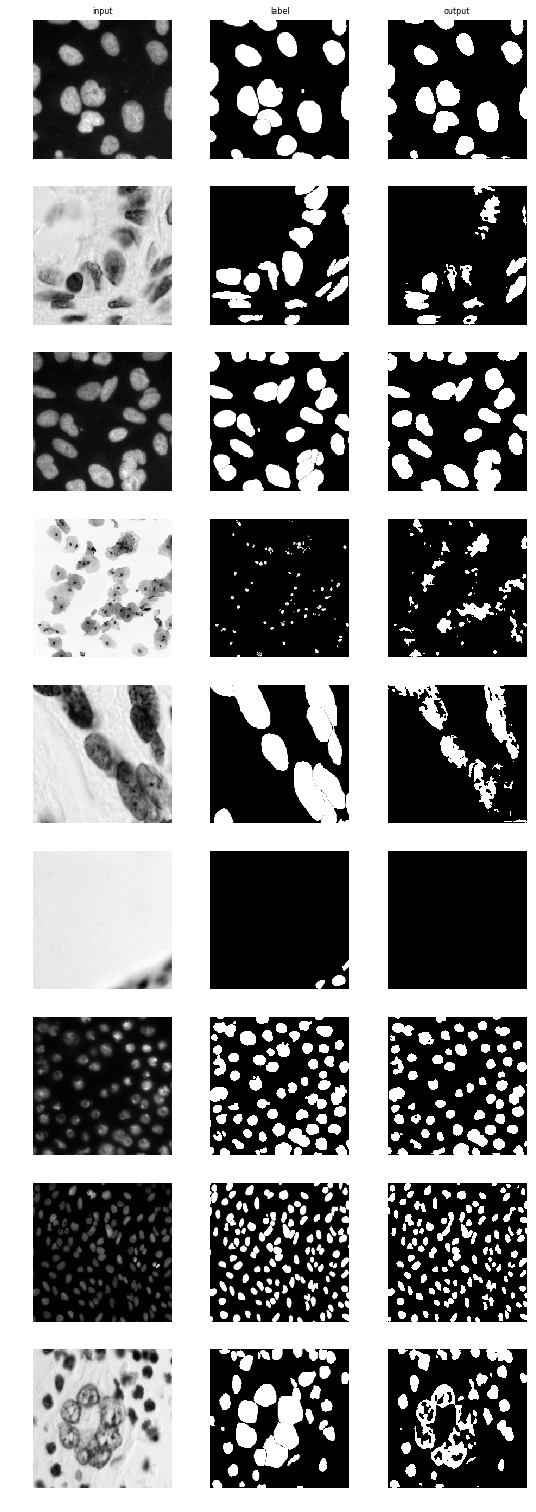

In [40]:
# List of difficult images in X_train
hard_idxs = [231, 353, 415, 533, 565, 586, 611, 628, 634] 

imgs_to_plot = []
for idx in hard_idxs:
    if idx < int(X_train.shape[0]):
        imgs_to_plot.append(X_train[idx])
        imgs_to_plot.append(Y_train[idx])
        imgs_to_plot.append(preds_train_t[idx])
    else:
        idx = idx-int(X_train.shape[0])
        imgs_to_plot.append(X_val[idx])
        imgs_to_plot.append(Y_val[idx])
        imgs_to_plot.append(preds_val_t[idx])
    
n = len(hard_idxs)
titles = ['input', 'label', 'output'] + ['']*(3*n-3)
plots(imgs_to_plot, figsize=(9,n*3), rows=n, titles=titles)
plt.savefig('output_examples/' + model_name + '.png')

In [ ]:
# Try on test set
ix = random.randint(0, len(preds_test_t))
plots([X_test[ix], preds_test_t[ix] if not USE_WEIGHTS else preds_test_t[ix]])

### Compute estimate of score

In [ ]:
""" Collection of methods to compute the score.
From: https://www.kaggle.com/raoulma/nuclei-dsb-2018-tensorflow-u-net-score-0-352

1. We start with a true and predicted mask, corresponding to one train image.

2. The true mask is segmented into different objects. Here lies a main source 
of error. Overlapping or touching nuclei are not separated but are labeled as 
one object. This means that the target mask can contain less objects than 
those that have been originally identified by humans.

3. In the same manner the predicted mask is segmented into different objects.

4. We compute all intersections between the objects of the true and predicted 
masks. Starting with the largest intersection area we assign true objects to 
predicted ones, until there are no true/pred objects left that overlap. 
We then compute for each true/pred object pair their corresponding intersection 
over union (iou) ratio. 

5. Given some threshold t we count the object pairs that have an iou > t, which
yields the number of true positives: tp(t). True objects that have no partner are 
counted as false positives: fp(t). Likewise, predicted objects without a counterpart
a counted as false negatives: fn(t).

6. Now, we compute the precision tp(t)/(tp(t)+fp(t)+fn(t)) for t=0.5,0.55,0.60,...,0.95
and take the mean value as the final precision (score).
"""

def get_labeled_mask(mask, cutoff=.5, min_object_size=1.):
    """Object segmentation by labeling the mask."""
    mask = mask.reshape(mask.shape[0], mask.shape[1])
    lab_mask = skimage.morphology.label(mask > cutoff) 
    
    # Keep only objects that are large enough.
    (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
    if (mask_sizes < min_object_size).any():
        mask_labels = mask_labels[mask_sizes < min_object_size]
        for n in mask_labels:
            lab_mask[lab_mask == n] = 0
        lab_mask = skimage.morphology.label(lab_mask > cutoff) 
    
    return lab_mask  

def get_iou(y_true_labeled, y_pred_labeled):
    """Compute non-zero intersections over unions."""
    # Array of different objects and occupied area.
    (true_labels, true_areas) = np.unique(y_true_labeled, return_counts=True)
    (pred_labels, pred_areas) = np.unique(y_pred_labeled, return_counts=True)

    # Number of different labels.
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    # Each mask has at least one identified object.
    if (n_true_labels > 1) and (n_pred_labels > 1):
        
        # Compute all intersections between the objects.
        all_intersections = np.zeros((n_true_labels, n_pred_labels))
        for i in range(y_true_labeled.shape[0]):
            for j in range(y_true_labeled.shape[1]):
                m = y_true_labeled[i,j]
                n = y_pred_labeled[i,j]
                all_intersections[m,n] += 1 

        # Assign predicted to true background.
        assigned = [[0,0]]
        tmp = all_intersections.copy()
        tmp[0,:] = -1
        tmp[:,0] = -1

        # Assign predicted to true objects if they have any overlap.
        for i in range(1, np.min([n_true_labels, n_pred_labels])):
            mn = list(np.unravel_index(np.argmax(tmp), (n_true_labels, n_pred_labels)))
            if all_intersections[mn[0], mn[1]] > 0:
                assigned.append(mn)
            tmp[mn[0],:] = -1
            tmp[:,mn[1]] = -1
        assigned = np.array(assigned)

        # Intersections over unions.
        intersection = np.array([all_intersections[m,n] for m,n in assigned])
        union = np.array([(true_areas[m] + pred_areas[n] - all_intersections[m,n]) 
                           for m,n in assigned])
        iou = intersection / union

        # Remove background.
        iou = iou[1:]
        assigned = assigned[1:]
        true_labels = true_labels[1:]
        pred_labels = pred_labels[1:]

        # Labels that are not assigned.
        true_not_assigned = np.setdiff1d(true_labels, assigned[:,0])
        pred_not_assigned = np.setdiff1d(pred_labels, assigned[:,1])
        
    else:
        # in case that no object is identified in one of the masks
        iou = np.array([])
        assigned = np.array([])
        true_labels = true_labels[1:]
        pred_labels = pred_labels[1:]
        true_not_assigned = true_labels
        pred_not_assigned = pred_labels
        
    # Returning parameters.
    params = {'iou': iou, 'assigned': assigned, 'true_not_assigned': true_not_assigned,
             'pred_not_assigned': pred_not_assigned, 'true_labels': true_labels,
             'pred_labels': pred_labels}
    return params

def get_score_summary(y_true, y_pred):
    """Compute the score for a single sample including a detailed summary."""
    
    y_true_labeled = get_labeled_mask(y_true)  
    y_pred_labeled = get_labeled_mask(y_pred)  
    
    params = get_iou(y_true_labeled, y_pred_labeled)
    iou = params['iou']
    assigned = params['assigned']
    true_not_assigned = params['true_not_assigned']
    pred_not_assigned = params['pred_not_assigned']
    true_labels = params['true_labels']
    pred_labels = params['pred_labels']
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    summary = []
    for i,threshold in enumerate(np.arange(0.5, 1.0, 0.05)):
        tp = np.sum(iou > threshold)
        fn = n_true_labels - tp
        fp = n_pred_labels - tp
        if (tp+fp+fn)>0: 
            prec = tp/(tp+fp+fn)
        else: 
            prec = 0
        summary.append([threshold, prec, tp, fp, fn])

    summary = np.array(summary)
    score = np.mean(summary[:,1]) # Final score.
    params_dict = {'summary': summary, 'iou': iou, 'assigned': assigned, 
                   'true_not_assigned': true_not_assigned, 
                   'pred_not_assigned': pred_not_assigned, 'true_labels': true_labels,
                   'pred_labels': pred_labels, 'y_true_labeled': y_true_labeled,
                   'y_pred_labeled': y_pred_labeled}
    
    return score, params_dict

def get_score(y_true, y_pred):
    """Compute the score for a batch of samples."""
    scores = []
    for i in range(len(y_true)):
        score,_ = get_score_summary(y_true[i], y_pred[i])
        scores.append(score)
    return np.array(scores)

def imshow_args(x):
    """Matplotlib imshow arguments for plotting."""
    if len(x.shape)==2: return x, cm.gray
    if x.shape[2]==1: return x[:,:,0], cm.gray
    return x, None

def plot_score_summary(y_true, y_pred):
    """Plot score summary for a single sample."""
    # Compute score and assign parameters.
    score, params_dict = get_score_summary(y_true, y_pred)
    
    assigned = params_dict['assigned']
    true_not_assigned = params_dict['true_not_assigned']
    pred_not_assigned = params_dict['pred_not_assigned']
    true_labels = params_dict['true_labels']
    pred_labels = params_dict['pred_labels']
    y_true_labeled = params_dict['y_true_labeled']
    y_pred_labeled = params_dict['y_pred_labeled']
    summary = params_dict['summary']

    n_assigned = len(assigned)
    n_true_not_assigned = len(true_not_assigned)
    n_pred_not_assigned = len(pred_not_assigned)
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    # Summary dataframe.
    summary_df = pd.DataFrame(summary,columns=['threshold','precision','tp','fp','fn'])
    print('Final score:', score)
    print(summary_df)

    # Plots.
    fig, axs = plt.subplots(2,3,figsize=(20,13))

    # True mask with true objects.
    img = y_true
    axs[0,0].imshow(img, cmap=cm.gray)
    axs[0,0].set_title('{}.) true mask: {} true objects'.format(n,'?')) #3
    
    # True mask with identified objects.
    #img = np.zeros(y_true.shape)
    #img[y_true_labeled > 0.5] = 255
    img, img_type = imshow_args(y_true_labeled)
    axs[0,1].imshow(img, img_type)
    axs[0,1].set_title('{}.) true mask: {} objects identified'.format(n, n_true_labels))
    
    # Predicted mask with identified objects.
    #img = np.zeros(y_true.shape)
    #img[y_pred_labeled > 0.5] = 255
    img, img_type = imshow_args(y_pred_labeled)
    axs[0,2].imshow(img, img_type)
    axs[0,2].set_title('{}.) predicted mask: {} objects identified'.format(
        n, n_pred_labels))

    # Prediction overlap with true mask.
    img = np.zeros(y_true.shape)
    img[y_true > 0.5] = 100
    for i,j in assigned: img[(y_true_labeled == i) & (y_pred_labeled == j)] = 255
    axs[1,0].set_title('{}.) {} pred. overlaps (white) with true objects (gray)'.format(
        n,len(assigned)))
    axs[1,0].imshow(img, cmap='gray', norm=None)

    # Intersection over union.
    img = np.zeros(y_true.shape)
    img[(y_pred_labeled > 0) & (y_pred_labeled < 100)] = 100
    img[(y_true_labeled > 0) & (y_true_labeled < 100)] = 100
    for i,j in assigned: img[(y_true_labeled == i) & (y_pred_labeled == j)] = 255
    axs[1,1].set_title('{}.) {} intersections (white) over unions (gray)'.format(
        n, n_assigned))
    axs[1,1].imshow(img, cmap='gray');

    # False positives and false negatives.
    img = np.zeros(y_true.shape)
    for i in pred_not_assigned: img[(y_pred_labeled == i)] = 255
    for i in true_not_assigned: img[(y_true_labeled == i)] = 100
    axs[1,2].set_title('{}.) no threshold: {} fp (white), {} fn (gray)'.format(
        n, n_pred_not_assigned, n_true_not_assigned))
    axs[1,2].imshow(img, cmap='gray');

In [ ]:
import skimage
import skimage.morphology
import matplotlib.cm as cm        

# Check the score metric for one sample. The predicted mask is simulated
# and can be modified in order to check the correct implementation of
# the score metric.
idx = np.random.randint(len(X_train)*0.1) + int(len(X_train)*0.9)
print(idx)
true_mask = Y_train[idx,:,:,0].copy()
lab_true_mask = get_labeled_mask(true_mask)
idx_val = idx-int(len(X_train)*0.9)
pred_mask = (preds_val_t[idx_val] if not USE_WEIGHTS else preds_val_t[idx_val][:,:,0]).squeeze()
plot_score_summary(true_mask, pred_mask) 

In [ ]:
from tqdm import tqdm

# evaluate score on validation set
scores = []
for idx in tqdm(range(int(len(X_train)*0.1))):
    idx_train = idx + int(len(X_train)*0.9)
    true_mask = Y_train[idx_train,:,:,0].copy()
    lab_true_mask = get_labeled_mask(true_mask)
    pred_mask = (preds_val_t[idx] if not USE_WEIGHTS else preds_val_t[idx][:,:,0]).squeeze()
    score, _ = get_score_summary(true_mask, pred_mask)
    scores.append(score)
print(np.mean(scores))

### Encode for submission

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
new_test_ids = []
rles = []
for n, id_ in tqdm(enumerate(test_ids)):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-2.csv', index=False)